In [1]:
# Importing packages and data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm

ozone = pd.read_csv('Daily_Census_Tract-Level_Ozone_Concentrations__2011-2014_20241125.csv')
chronic_disease = pd.read_csv('U.S._Chronic_Disease_Indicators__CDI___2023_Release_20241125.csv')

## Preliminary data cleaning

In [2]:
codes = [30, 16, 45, 6, 36, 48]
state_codes = ['MT', 'ID', 'SC', 'CA', 'NY', 'TX']
questions = ['Current asthma prevalence among adults aged >= 18 years', 'Invasive cancer (all sites combined), incidence', 
             'Prevalence of chronic kidney disease among adults aged >= 18 years', 'Prevalence of chronic obstructive pulmonary disease among adults >= 18',
             'Prevalence of diagnosed diabetes among adults aged >= 18 years', 'Mortality from diseases of the heart']

# Chronic diseases
disease_q = chronic_disease[chronic_disease['Question'].isin(questions)] # Filtering to only include chosen questions
disease_q = disease_q[disease_q['YearStart'].isin([2011,2012,2013,2014])]
disease_q = disease_q[disease_q['LocationID'].isin(codes)]
disease_q = disease_q[['YearStart', 'LocationDesc', 'LocationID', 'Topic', 'Question', 'DataValueUnit', 'DataValue']]

filter = chronic_disease[chronic_disease['Question'].str.contains('mortality') | chronic_disease['Question'].str.contains('Mortality')] # Looking at mortality
diseases = filter[['YearStart', 'LocationDesc', 'LocationID', 'Topic', 'Question', 'DataValueUnit', 'DataValue']]
diseases = diseases[diseases['LocationID'].isin(codes)] # Filtering to chosen states
diseases

,YearStart,LocationDesc,LocationID,Topic,Question,DataValueUnit,DataValue
74,2010,California,6.0,Asthma,Asthma mortality rate,NaN,403.0
75,2017,California,6.0,Asthma,Asthma mortality rate,NaN,399.0
86,2020,Idaho,16.0,Asthma,Asthma mortality rate,Number,23.0
87,2010,Idaho,16.0,Asthma,Asthma mortality rate,NaN,21.0
106,2012,Montana,30.0,Asthma,Asthma mortality rate,NaN,NaN
...,...,...,...,...,...,...,...
617982,2015,South Carolina,45.0,Diabetes,Mortality with diabetic ketoacidosis reported ...,"cases per 100,000",NaN
617987,2015,Montana,30.0,Diabetes,Mortality with diabetic ketoacidosis reported ...,"cases per 100,000",NaN
618005,2013,Texas,48.0,Diabetes,Mortality with diabetic ketoacidosis reported ...,NaN,NaN
618014,2015,Texas,48.0,Diabetes,Mortality with diabetic ketoacidosis reported ...,"cases per 100,000",NaN


## EDA

Average ozone concentration by state

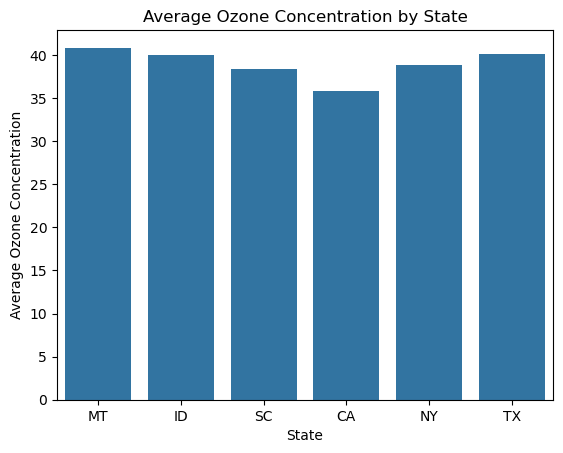

In [3]:
# Ozone
ozone_filter = ozone[ozone['statefips'].isin(codes)] # Filtering to only chosen states
ozone_total = ozone_filter.groupby('statefips')['ds_o3_pred'].mean().reset_index()
ozone_total['state'] = state_codes
sns.barplot(data=ozone_total, x='state', y='ds_o3_pred')
plt.title('Average Ozone Concentration by State')
plt.xlabel('State')
plt.ylabel('Average Ozone Concentration')
plt.show();

Comparing age distributions and COPD prevalence across states

In [7]:
# Looking at COPD specifically
copd = disease_q[disease_q['Topic']=='Chronic Obstructive Pulmonary Disease']
copd2011 = copd[copd.YearStart == 2011]
copd_grouped = copd2011.groupby('LocationDesc')[['DataValue']].mean()
copd_grouped = copd_grouped.reset_index()
copd_grouped = copd_grouped.rename(columns={'LocationDesc':'state', 'DataValue':'prevalence'})
copd_grouped

,state,prevalence
0,California,5.250000
1,Idaho,5.180000
2,Montana,7.033333
3,New York,5.758333
4,South Carolina,8.341667
5,Texas,6.442857


In [8]:
age2011 = pd.read_csv('age2011.csv')

# Cleaning age data
pattern = r'[a-zA-Z]([0-9]+)'
def clean(df):
    # Cleans column names and drops unnecessary columns
    df.columns = df.iloc[0].str.replace('!!', ' ')
    df = df.drop(df.columns[-1], axis=1)
    df = df.drop(columns=df.columns[df.columns.str.contains('Margin of Error')])
    df = df.drop(columns=df.columns[df.columns.str.contains('PERCENT IMPUTED')])
    df = df.drop(columns=df.columns[df.columns.str.contains('PERCENT ALLOCATED')])
    df = df.drop(columns=df.columns[df.columns.str.contains('Male')])
    df = df.drop(columns=df.columns[df.columns.str.contains('Female')])
    df = df.drop(columns=df.columns[df.columns.str.contains('dependency')])
    df = df.drop(columns=df.columns[df.columns.str.contains('SUMMARY INDICATORS')])
    df = df.drop(columns=df.columns[df.columns.str.contains('SELECTED AGE CATEGORIES')])
    df['Geography'] = df['Geography'].str.extract(pattern) # Extracting correct GEOID
    df = df.iloc[1:]
    return df

age_clean = clean(age2011)
age_cols = age_clean.columns[3:]
age = age_clean.melt(id_vars=['Geography', 'Geographic Area Name'], 
                  value_vars=age_cols, 
                  var_name='age_group', 
                  value_name='percent_pop')

age['age_group'] = age['age_group'].str.extract(r'^Total Estimate AGE (.*)$')
age['percent_pop'] = age['percent_pop'].astype('float')

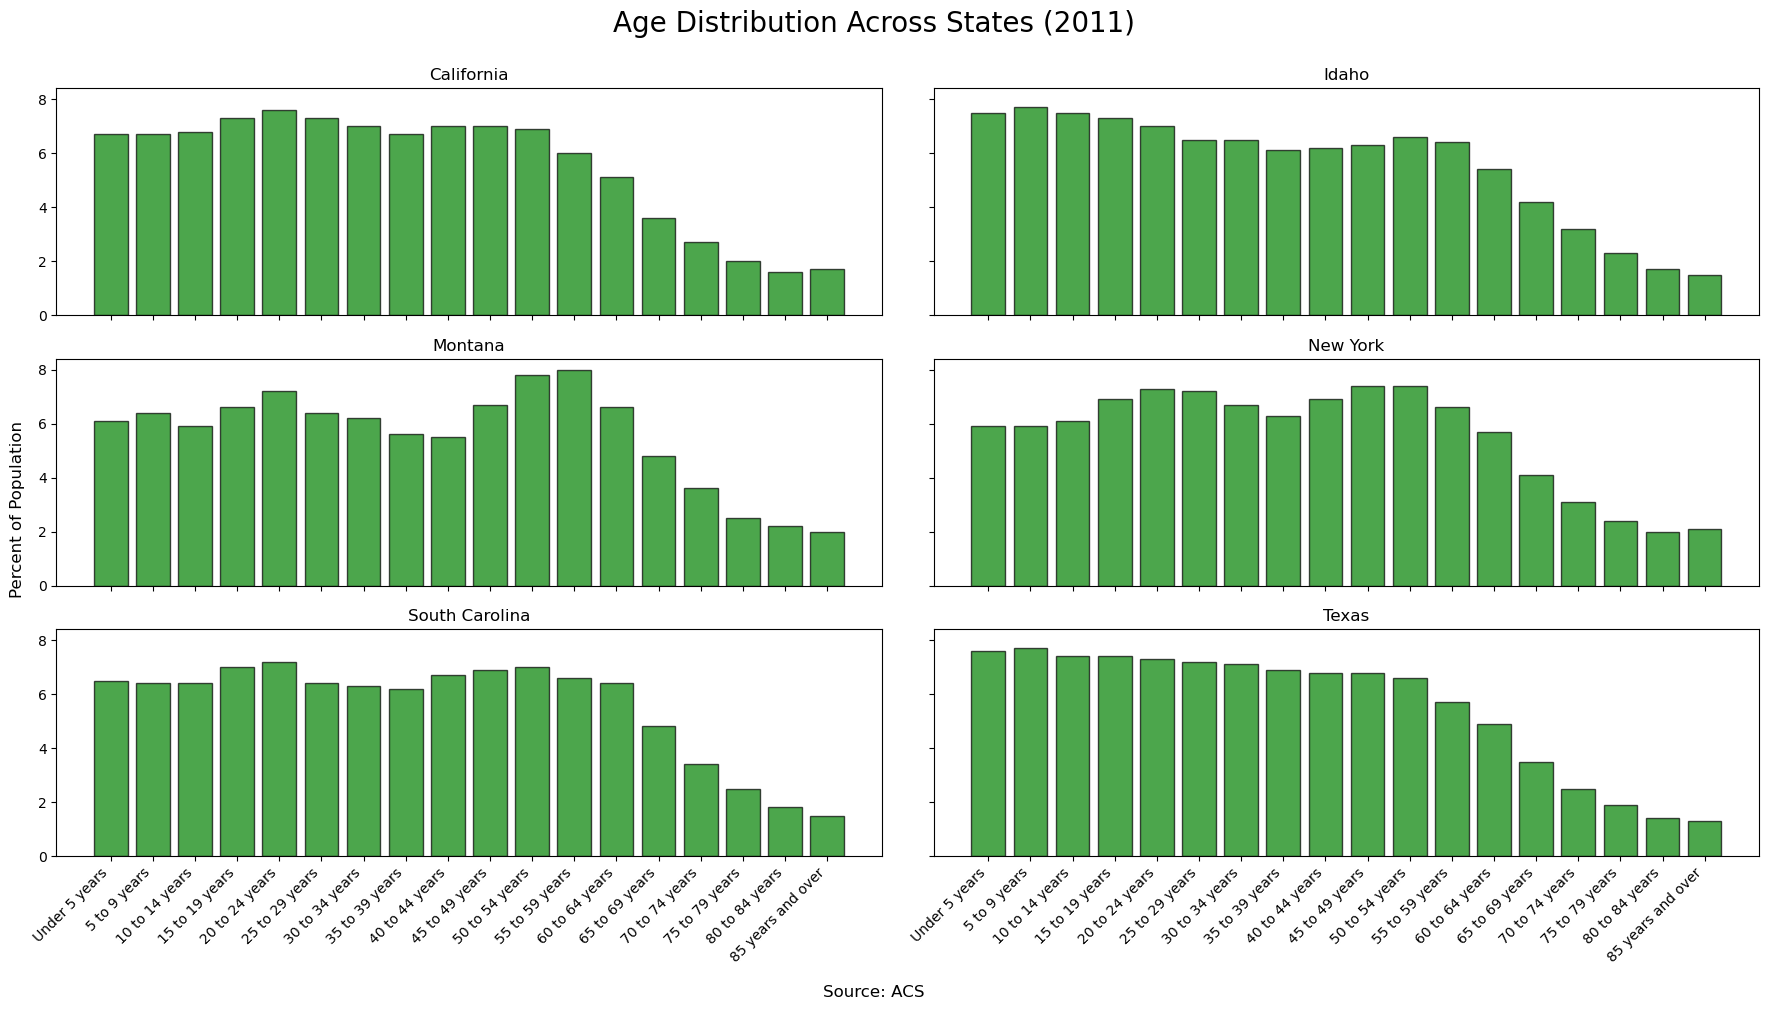

In [9]:
# Plotting age distributions
states = ['California', 'Idaho', 'Montana', 'New York', 'South Carolina', 'Texas']
plot, axes = plt.subplots(3, 2, figsize=(18, 10), sharex=True, sharey=True)
axes = axes.flatten()

# Plot each state separately
for ax, state in zip(axes, states):
    age_state = age[age['Geographic Area Name'] == state]
    ax.bar(age_state['age_group'], age_state['percent_pop'], color='green', edgecolor='black', alpha=0.7)
    ax.set_title(f'{state}')
    ax.set_xticks(range(len(age_state['age_group'])))
    ax.set_xticklabels(age_state['age_group'], rotation=45, ha='right')

plot.supylabel('Percent of Population')
plot.supxlabel('Source: ACS')

plot.suptitle('Age Distribution Across States (2011)', y=1, size=20)

plt.tight_layout()
plt.show()

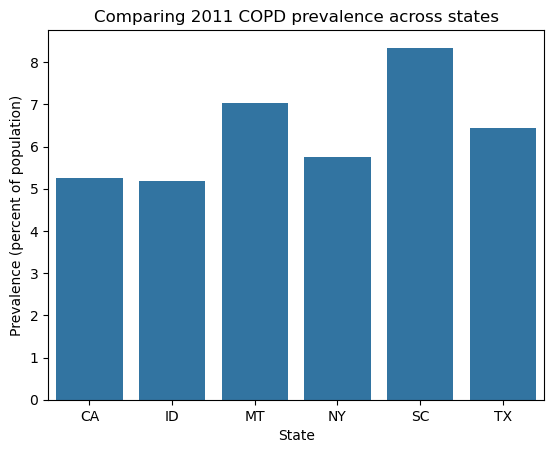

In [10]:
# Plotting COPD prevalence across all states
state_codes = ['CA', 'ID', 'MT', 'NY', 'SC', 'TX']
copd_grouped['st_code'] = state_codes
sns.barplot(data=copd_grouped, x='st_code', y='prevalence')
plt.xlabel('State')
plt.ylabel('Prevalence (percent of population)')
plt.title('Comparing 2011 COPD prevalence across states');

## Research questions

QUESTIONS/TOPICS:
- Current asthma prevalence among adults aged >= 18 years
- Invasive cancer (all sites combined), incidence
- Prevalence of chronic kidney disease among adults aged >= 18 years
- Prevalence of chronic obstructive pulmonary disease among adults >= 18
- Prevalence of diagnosed diabetes among adults aged >= 18 years
- Mortality from diseases of the heart

## Multiple Hypothesis Testing
Research question: Is there an association between ground-level ozone concentration and the prevalence of different chronic diseases?

In [11]:
questions = ['Current asthma prevalence among adults aged >= 18 years', 'Invasive cancer (all sites combined), incidence', 
             'Prevalence of chronic kidney disease among adults aged >= 18 years', 'Prevalence of chronic obstructive pulmonary disease among adults >= 18',
             'Prevalence of diagnosed diabetes among adults aged >= 18 years', 'Mortality from diseases of the heart']

filtered = chronic_disease[chronic_disease['Question'].isin(questions)]
filtered = filtered[filtered['LocationID'].isin(codes)]
filtered = filtered[['YearStart', 'YearEnd', 'LocationDesc', 'LocationID', 'Topic', 'Question', 'DataValueUnit', 'DataValue', 'DataSource',
                     'StratificationCategoryID1', 'Stratification1']]
filtered = filtered[filtered['YearStart'].isin([2011, 2012, 2013, 2014])]

# Separating each disease
asthma = filtered[filtered.Topic == 'Asthma']
cancer = filtered[filtered['Topic'].str.contains('Cancer')]
kidney = filtered[filtered['Topic'].str.contains('Kidney')]
copd = filtered[filtered['Topic'].str.contains('Pulmonary')]
diabetes = filtered[filtered['Topic'].str.contains('Diabetes')]
heart = filtered[filtered['Topic'].str.contains('Cardiovascular')]

# Filtering ozone data to only include states we aren't interested in
ozone = ozone[ozone['statefips'].isin(codes)]
median_ozone = ozone['ds_o3_pred'].median()
ozone['high'] = ozone['ds_o3_pred'] > median_ozone # Classifying ozone as "high" if it is above the median

In [12]:
# Merging chronic disease and ozone data, cleaning column names
def clean_and_merge(df):
    merge = pd.merge(df, ozone, left_on=['YearStart', 'LocationID'], right_on=['year', 'statefips'])
    merge = merge[['year', 'statefips', 'LocationDesc', 'Topic', 'Question', 'DataValueUnit', 'DataValue', 'ds_o3_pred', 'high', 'DataSource',
                   'StratificationCategoryID1', 'Stratification1']]
    merge = merge.rename(columns={'LocationDesc':'location', 'Topic':'topic', 'Question':'question', 'DataValueUnit':'unit', 'DataValue':'value'})
    merge = merge[merge['StratificationCategoryID1'] == 'OVERALL']
    merge = merge[['year', 'statefips', 'location', 'topic', 'question', 'unit', 'value', 'ds_o3_pred', 'high']]
    df = merge
    return df

kidney = clean_and_merge(kidney)
kidney = kidney[kidney.unit == '%']
asthma = clean_and_merge(asthma)
asthma = asthma[asthma.unit == '%']
cancer = clean_and_merge(cancer)
cancer = cancer[cancer.unit == 'per 100,000']
copd = clean_and_merge(copd)
copd = copd[copd.unit == '%']
diabetes = clean_and_merge(diabetes)
diabetes = diabetes[diabetes.unit == '%']
heart = clean_and_merge(heart)
heart = heart[heart.unit == 'cases per 100,000']

Hypotheses:

Null: There is no difference in the number of cases of [CHRONIC DISEASE] between areas with high ozone concentration and low ozone concentration.

Alternative: There is a difference in the number of cases  of [CHRONIC DISEASE] between areas with high ozone concentration and low ozone concentration.

In [13]:
def ab_test(df, reps):
    differences = []
    # Find observed difference in means
    grouped = df.groupby('high')[['value']].mean()
    means = grouped['value'].values
    observed_diff = abs(means[1] - means[0]) # Subtracting mean of high ozone locations from mean of low ozone locations
    print(means[1]-means[0])

    for i in np.arange(reps):
        # Shuffle labels
        shuffled = np.random.permutation(df['high'])
        df['shuffled'] = shuffled
    
        # Take new difference in means from shuffled labels
        shuffle_group = df.groupby('shuffled')[['value']].mean()
        new_means = shuffle_group['value'].values
        diff = abs(new_means[1] - new_means[0])
        differences.append(diff) # these should be 0

    p_val = np.count_nonzero(differences >= observed_diff) / reps # this should be close to 0 in order to reject null 
    return p_val

In [14]:
repetitions = 5000

np.random.seed(10)
cancer_p = ab_test(cancer, repetitions)
print('cancer: ' + str(cancer_p))
copd_p = ab_test(copd, repetitions)
print('copd: ' + str(copd_p))
heart_p = ab_test(heart, repetitions)
print('cardiovascular disease: ' + str(heart_p))
diabetes_p = ab_test(diabetes, repetitions)
print('diabetes: ' + str(diabetes_p))
asthma_p = ab_test(asthma, repetitions)
print('asthma: ' + str(asthma_p))
kidney_p = ab_test(kidney, repetitions)
print('kidney disease: ' + str(kidney_p))

p_vals = [cancer_p, copd_p, heart_p, diabetes_p, asthma_p, kidney_p]
p_vals.sort() # Sorting p-values
p_vals

-61.712500000000034
cancer: 0.0006
-0.4583333333333339
copd: 0.1068
-18.82916666666665
cardiovascular disease: 0.0056
1.548571428571428
diabetes: 0.001
-0.7333333333333325
asthma: 0.009
0.1958333333333333
kidney disease: 0.035


[0.0006, 0.001, 0.0056, 0.009, 0.035, 0.1068]

In [15]:
tests = ['cancer', 'diabetes', 'heart', 'asthma', 'kidney', 'copd'] # Sorted labels

In [16]:
# Bonferroni correction (controlling FWER)
fpr = 0.01
num_tests = 6
new_threshold = fpr / num_tests

rejected = []
for i in range(num_tests):
    p_val = p_vals[i]
    test = tests[i]
    if p_val <= new_threshold:
        rejected.append(test)

print('rejected nulls: ' + str(rejected))

rejected nulls: ['cancer', 'diabetes']


In [17]:
# Benjamini Yekutieli (controlling FDR)
c_m = 1/1 + 1/2 + 1/3 + 1/4 + 1/5 + 1/6

thresholds = (np.arange(1, num_tests+1) / (num_tests + c_m)) * fpr

rejections = [] 

for i in range(num_tests):
    p = p_vals[i]
    thresh = thresholds[i]
    print(i)
    print(p <= thresh)

new_thresh = p_vals[1]

for i in range(num_tests):
    p_val = p_vals[i]
    test = tests[i]
    if p_val <= new_thresh:
        rejections.append(test)

print('rejected nulls: ' + str(rejections))

0
True
1
True
2
False
3
False
4
False
5
False
rejected nulls: ['cancer', 'diabetes']
